In [1]:
import os
import random

import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage
from PIL import Image
import cv2

from utils import LabelNormalize, DeNormalize

/home/ma-user/anaconda3/envs/PyTorch-1.11.0/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


除模型部分外，其余代码与CSRNet实验代码基本一致。

In [2]:
class SHHB(Dataset):
    def __init__(self, data_path, mode='train', main_transform=None, img_transform=None, gt_transform=None):
        self.img_path = data_path + '/' + mode + '_data/img'
        self.gt_path = data_path + '/' + mode + '_data/den'
        self.data_files = [filename for filename in os.listdir(self.img_path) \
                           if os.path.isfile(os.path.join(self.img_path,filename))]
        self.num_samples = len(self.data_files) 
        self.main_transform=main_transform  
        self.img_transform = img_transform
        self.gt_transform = gt_transform     
    
    def __getitem__(self, index):
        fname = self.data_files[index]
        img, den = self._read_image_and_gt(fname)
        if self.main_transform is not None:
            img, den = self.main_transform(img, den) 
        if self.img_transform is not None:
            img = self.img_transform(img)         
        if self.gt_transform is not None:
            den = self.gt_transform(den)               
        return img, den

    def __len__(self):
        return self.num_samples

    def _read_image_and_gt(self, fname):
        img = Image.open(os.path.join(self.img_path, fname))
        if img.mode == 'L':
            img = img.convert('RGB')
        den = pd.read_csv(os.path.join(self.gt_path, os.path.splitext(fname)[0] + '.csv'), sep=',', header=None).values
        den = den.astype(np.float32, copy=False)    
        den = cv2.resize(den, (den.shape[1] // 8, den.shape[0] // 8), interpolation=cv2.INTER_CUBIC) * 64
        return img, den

    def get_num_samples(self):
        return self.num_samples

In [3]:
def get_data_loader(dataset_path, batch_size=8, mode='train'):
    assert mode == 'train' or mode == 'test'
    mean_std = ([0.485, 0.456, 0.406], 
                [0.229, 0.224, 0.225])
    log_para = 100
    img_transform = Compose([
        ToTensor(),
        Normalize(*mean_std)
    ])
    gt_transform = Compose([
        LabelNormalize(log_para)
    ])
    restore_transform = Compose([
        DeNormalize(*mean_std),
        ToPILImage()
    ])
    main_transform = None
    dataset = None
    data_loader = None
    if mode == 'train':
        dataset = SHHB(dataset_path, 
                    'train', 
                    main_transform=main_transform, 
                    img_transform=img_transform, 
                    gt_transform=gt_transform)
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        train_data_loader = DataLoader(train_dataset, 
                                batch_size=batch_size, 
                                num_workers=8, 
                                shuffle=True, 
                                drop_last=True)
        val_data_loader = DataLoader(val_dataset, 
                                batch_size=batch_size, 
                                num_workers=8, 
                                shuffle=True, 
                                drop_last=True)
        return train_data_loader, val_data_loader, log_para, restore_transform
    elif mode == 'test':
        main_transform = None
        dataset = SHHB(dataset_path, 
                    'test', 
                    main_transform=main_transform, 
                    img_transform=img_transform, 
                    gt_transform=gt_transform)
        data_loader = DataLoader(dataset, 
                                batch_size=batch_size, 
                                num_workers=8, 
                                shuffle=True, 
                                drop_last=True)
        return data_loader, log_para, restore_transform

In [4]:
chk_train_loader, chk_val_loader, _, _ = get_data_loader('./dataset', 4, 'train')
train_img, train_gt = next(iter(chk_train_loader))
print(train_img.shape, train_gt.shape)
val_img, val_gt = next(iter(chk_val_loader))
print(val_img.shape, val_gt.shape)
chk_test_loader, _, _ = get_data_loader('./dataset', 1, 'test')
test_img, test_gt  = next(iter(chk_test_loader))
print(test_img.shape, test_gt.shape)

torch.Size([4, 3, 768, 1024]) torch.Size([4, 96, 128])
torch.Size([4, 3, 768, 1024]) torch.Size([4, 96, 128])
torch.Size([1, 3, 768, 1024]) torch.Size([1, 96, 128])


**任务1. 实现 convDU 和 convLR 。**

**具体要求：**

实现两个特殊的卷积类 convDU 和 convLR，分别用于捕获图像中的垂直（上到下、下到上）和水平（左到右、右到左）方向上的空间依赖关系。这两个卷积层将被用于一个更大的卷积神经网络VGGSFCN中，以改善网络对空间布局和上下文信息的理解。

convDU：使用一个卷积操作，卷积核大小为 (9, 1)，强调垂直方向上的特征整合。

convLR：使用一个卷积操作，卷积核大小为 (1, 9)，强调水平方向上的特征整合。

**convDU实现提示：**

**模块定义：**
1. 卷积层（self.conv）定义：对于 convDU，需要定义一个含有单个 nn.Conv2d 和 nn.ReLU 激活函数的 nn.Sequential，该卷积层的输入输出通道数相同，由构造函数中的 in_out_channels 参数给定。
2. 边缘填充：确保卷积时使用了正确的填充，使得经过卷积操作后的特征图尺寸不变。计算填充时需要考虑到卷积核大小，以实现所需的填充效果。

**前向传播：**
1. 遍历输入特征图的高度：convDU 需要在垂直方向（即，每一行）上遍历处理特征图。
2. 处理每一行：可以使用 tensor.select(dim, index) 选择第 index 行（记得特征图的维度是 [batch_size, channels, height, width]）。注意对选中的行变形，使其具有 [batch_size, channels, 1, width] 的形状，以适配卷积层。
3. 应用卷积并累积结果：在处理第一行时，直接将其添加到 fea_stack 列表中，因为它上面没有其他行可以累积。对于其他行，先通过 self.conv 对上一步骤得到的行应用卷积操作，然后将卷积的输出与 fea_stack 中前一行的累积结果相加，以实现信息的累积。将这个累积结果添加到 fea_stack。
4. 从下到上再次遍历：为了在垂直方向上双向传播信息，再次遍历特征图的每一行，这次是从下到上。对每一行重复上述累积过程，但方向相反。
5. 合并结果：可以使用 torch.cat(List[tensor], dim) 将 fea_stack 中所有行合并回一个完整的特征图，恢复原始的 [batch_size, channels, height, width] 形状。

**convLR实现提示：**

与 convDU 类似，但方向改为水平，不再赘述。

**任务2. 补全 VGGSFCN 的 _make_layers 方法（与 CSRNet 中的 _make_layers 方法是一致的）和前向传播。**

关于模型配置细节，可以参考SFCN论文补充材料Table1。

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models


class convDU(nn.Module):

    def __init__(self,
        in_out_channels=2048,
        kernel_size=(9, 1)
        ):
        super(convDU, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_out_channels, in_out_channels, kernel_size, stride=1, padding=((kernel_size[0]-1) // 2, (kernel_size[1]-1) // 2)),
            nn.ReLU(inplace=True)
            )

    def forward(self, fea):
        n, c, h, w = fea.size()
        fea_stack = []
        for i in range(h):
            i_fea = fea.select(2, i).resize(n, c, 1, w)
            if i == 0:
                fea_stack.append(i_fea)
                continue
            fea_stack.append(self.conv(fea_stack[i-1]) + i_fea)

        for i in range(h):
            pos = h - i - 1
            if pos == h - 1:
                continue
            fea_stack[pos] = self.conv(fea_stack[pos+1]) + fea_stack[pos]
        fea = torch.cat(fea_stack, 2)
        return fea


class convLR(nn.Module):
    def __init__(self,
        in_out_channels=2048,
        kernel_size=(1, 9)
        ):
        super(convLR, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_out_channels, in_out_channels, kernel_size, stride=1, padding=((kernel_size[0]-1 ) // 2, (kernel_size[1]-1) // 2)),
            nn.ReLU(inplace=True)
            )

    def forward(self, fea):
        n, c, h, w = fea.size()
        fea_stack = []
        for i in range(w):
            i_fea = fea.select(3, i).resize(n, c, h, 1)
            if i == 0:
                fea_stack.append(i_fea)
                continue
            fea_stack.append(self.conv(fea_stack[i-1]) + i_fea)

        for i in range(w):
            pos = w - i - 1
            if pos == w - 1:
                continue
            fea_stack[pos] = self.conv(fea_stack[pos+1]) + fea_stack[pos]
        fea = torch.cat(fea_stack, 3)
        return fea


class VGGSFCN(nn.Module):
    def __init__(self, ):
        super(VGGSFCN, self).__init__()
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat  = [512, 512, 512, 256, 128, 64]
        self.frontend = self._make_layers(self.frontend_feat)
        self.backend = self._make_layers(self.backend_feat, in_channels=512, dilation=True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        mod = models.vgg16(pretrained=False)
        mod.load_state_dict(torch.load('./vgg16-397923af.pth'))
        self._initialize_weights()
        self.frontend.load_state_dict(mod.features[0:23].state_dict())
        self.convDU = convDU(in_out_channels=64, kernel_size=(1, 9))
        self.convLR = convLR(in_out_channels=64, kernel_size=(9, 1))
        self.output_layer = nn.Sequential(nn.Conv2d(64, 1, kernel_size=1), nn.ReLU())

    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.convDU(x)
        x = self.convLR(x)
        x = self.output_layer(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0.0, std=0.01)
                if m.bias is not None:
                    m.bias.data.fill_(0)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.fill_(1)
                m.bias.data.fill_(0)

    def _make_layers(self, cfg, in_channels=3, batch_norm=False, dilation=False):
        if dilation:
            d_rate = 2
        else:
            d_rate = 1
        layers = []
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate,dilation = d_rate)
                if batch_norm:
                    layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        return nn.Sequential(*layers)

In [6]:
model = VGGSFCN()
ret = model(torch.randn(4, 3, 64, 64))
print(ret.shape)

/home/ma-user/anaconda3/envs/PyTorch-1.11.0/lib/python3.7/site-packages/torch/_tensor.py:549: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


torch.Size([4, 1, 8, 8])


In [7]:
def train(net, train_loader, device, criterion, optimizer, scheduler, epoch):
    net.train()
    total_loss = 0
    for inputs, gt in train_loader:
        inputs, gt = inputs.to(device), gt.to(device)
        pred_map = net(inputs).squeeze()
        optimizer.zero_grad()
        loss = criterion(pred_map, gt)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    scheduler.step()
        
    avg_loss = total_loss / len(train_loader)
    return avg_loss

def val(net, val_loader, device, criterion, epoch, log_para):
    net.eval()
    total_loss = 0
    gt_cnt_lis = []
    pred_cnt_lis = []
    with torch.no_grad():
        for inputs, gt in val_loader:
            inputs, gt = inputs.to(device), gt.to(device)
            pred_map = net(inputs).squeeze()

            loss = criterion(pred_map, gt)
            total_loss += loss.item()
            gt = gt.data.cpu().numpy()
            pred_map = pred_map.data.cpu().numpy()
            for i in range(gt.shape[0]):
                gt_cnt = np.sum(gt[i]) / log_para
                pred_cnt = np.sum(pred_map[i]) / log_para
                gt_cnt_lis.append(float(gt_cnt))
                pred_cnt_lis.append(float(pred_cnt))

    avg_loss = total_loss / len(val_loader)
    y_true = np.array(gt_cnt_lis)
    y_pred = np.array(pred_cnt_lis)
    rmse = np.sqrt(np.mean((y_true - y_pred)**2)) 
    mae = np.mean(np.abs(y_true - y_pred))
    return avg_loss, rmse, mae

In [8]:
import torch_npu
print(torch.cuda.is_available())

from torch_npu.contrib import transfer_to_npu
print(torch.cuda.is_available())
print(torch.npu.is_available())

False
True
True


/home/ma-user/anaconda3/envs/PyTorch-1.11.0/lib/python3.7/site-packages/torch_npu/contrib/transfer_to_npu.py:167: ImportWarning: 
    *************************************************************************************************************
    The torch.Tensor.cuda and torch.nn.Module.cuda are replaced with torch.Tensor.npu and torch.nn.Module.npu now..
    The torch.cuda.DoubleTensor is replaced with torch.npu.FloatTensor cause the double type is not supported now..
    The backend in torch.distributed.init_process_group set to hccl now..
    The torch.cuda.* and torch.cuda.amp.* are replaced with torch.npu.* and torch.npu.amp.* now..
    The device parameters have been replaced with npu in the function below:
    torch.logspace, torch.randint, torch.hann_window, torch.rand, torch.full_like, torch.ones_like, torch.rand_like, torch.randperm, torch.arange, torch.frombuffer, torch.normal, torch._empty_per_channel_affine_quantized, torch.empty_strided, torch.empty_like, torch.scalar_t

这里使用了torch.optim.lr_scheduler.StepLR，其为PyTorch 中一个用于调整学习率的工具，它根据预设的步数（epochs）逐步减小学习率。通过逐步降低学习率，StepLR 能帮助模型在训练的后期阶段稳定下来，从而可能提高模型的准确率和收敛速度。

In [9]:
%%time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader, val_loader, log_para, _ = get_data_loader('./dataset', batch_size=8, mode='train')
net = VGGSFCN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=1e-5, momentum=0.95, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.995)

# 可适当减小训练轮数，根据经验来说，200轮上下即可得到相对不错的结果
num_epochs = 600
for epoch in range(num_epochs):
    best_val_rmse = np.inf
    best_val_mae = np.inf
    train_loss = train(net, train_loader, device, criterion, optimizer, scheduler, epoch)
    val_loss, val_rmse, val_mae = val(net, val_loader, device, criterion, epoch, log_para)
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, \
          Val RMSE: {val_rmse:.4f}, Val MAE: {val_mae:.4f}')
    if val_rmse < best_val_rmse or val_mae < best_val_mae:
        best_val_rmse = np.min([best_val_rmse, val_rmse])
        best_val_mae = np.min([best_val_mae, val_mae])
        torch.save(net.state_dict(), f'{net.__class__.__name__}_best_model.pth')

Epoch 1, Train Loss: 50.0929, Val Loss: 72.9085,           Val RMSE: 178.5084, Val MAE: 127.6377
Epoch 2, Train Loss: 49.9246, Val Loss: 72.6120,           Val RMSE: 164.9897, Val MAE: 109.7145
Epoch 3, Train Loss: 49.6458, Val Loss: 72.1671,           Val RMSE: 141.5084, Val MAE: 85.9437
Epoch 4, Train Loss: 49.3895, Val Loss: 71.8218,           Val RMSE: 124.5277, Val MAE: 85.7661
Epoch 5, Train Loss: 49.2434, Val Loss: 71.5946,           Val RMSE: 124.9059, Val MAE: 83.2071
Epoch 6, Train Loss: 48.9822, Val Loss: 70.9494,           Val RMSE: 120.0041, Val MAE: 89.3502
Epoch 7, Train Loss: 48.3507, Val Loss: 69.0891,           Val RMSE: 118.7450, Val MAE: 100.0591
Epoch 8, Train Loss: 46.5355, Val Loss: 64.2591,           Val RMSE: 98.0404, Val MAE: 68.9759
Epoch 9, Train Loss: 43.7590, Val Loss: 59.4795,           Val RMSE: 91.1617, Val MAE: 82.1366
Epoch 10, Train Loss: 42.4952, Val Loss: 57.6591,           Val RMSE: 66.4698, Val MAE: 49.4543
Epoch 11, Train Loss: 41.6877, Val Loss

In [10]:
import matplotlib.pyplot as plt

def visualize_density_map(pred_maps, gts, idx):
    n = pred_maps.shape[0]
    _, axes = plt.subplots(n, 3, figsize=(15, 5 * n))

    for i in range(n):
        pred_map = pred_maps[i]
        gt = gts[i]
        pred_map = (pred_map - np.min(pred_map)) / (np.max(pred_map) - np.min(pred_map))
        gt = (gt - np.min(gt)) / (np.max(gt) - np.min(gt))
        diff = pred_map - gt
        axes[i, 0].imshow(pred_map, cmap='jet', interpolation='nearest')
        axes[i, 0].set_title(f'Density Map Prediction')
        axes[i, 1].imshow(gt, cmap='jet', interpolation='nearest')
        axes[i, 1].set_title(f'Density Map Ground Truth')
        axes[i, 2].imshow(diff, cmap='jet', interpolation='nearest')
        axes[i, 2].set_title(f'Difference')

    plt.tight_layout()
    plt.show()

def test(net, test_loader, device, log_para):
    net.eval()
    gt_cnt_lis = []
    pred_cnt_lis = []
    visual_iter_idx_lis = [0]
    with torch.no_grad():
        for idx, (inputs, gt) in enumerate(test_loader):
            inputs, gt = inputs.to(device), gt.to(device)
            pred_map = net(inputs).squeeze()

            gt = gt.data.cpu().numpy()
            pred_map = pred_map.data.cpu().numpy()
            if idx in visual_iter_idx_lis:
                visualize_density_map(pred_map, gt, idx)
            for i in range(gt.shape[0]):
                gt_cnt = np.sum(gt[i]) / log_para
                pred_cnt = np.sum(pred_map[i]) / log_para
                gt_cnt_lis.append(float(gt_cnt))
                pred_cnt_lis.append(float(pred_cnt))

    y_true = np.array(gt_cnt_lis)
    y_pred = np.array(pred_cnt_lis)
    rmse = np.sqrt(np.mean((y_true - y_pred)**2)) 
    mae = np.mean(np.abs(y_true - y_pred))
    return rmse, mae

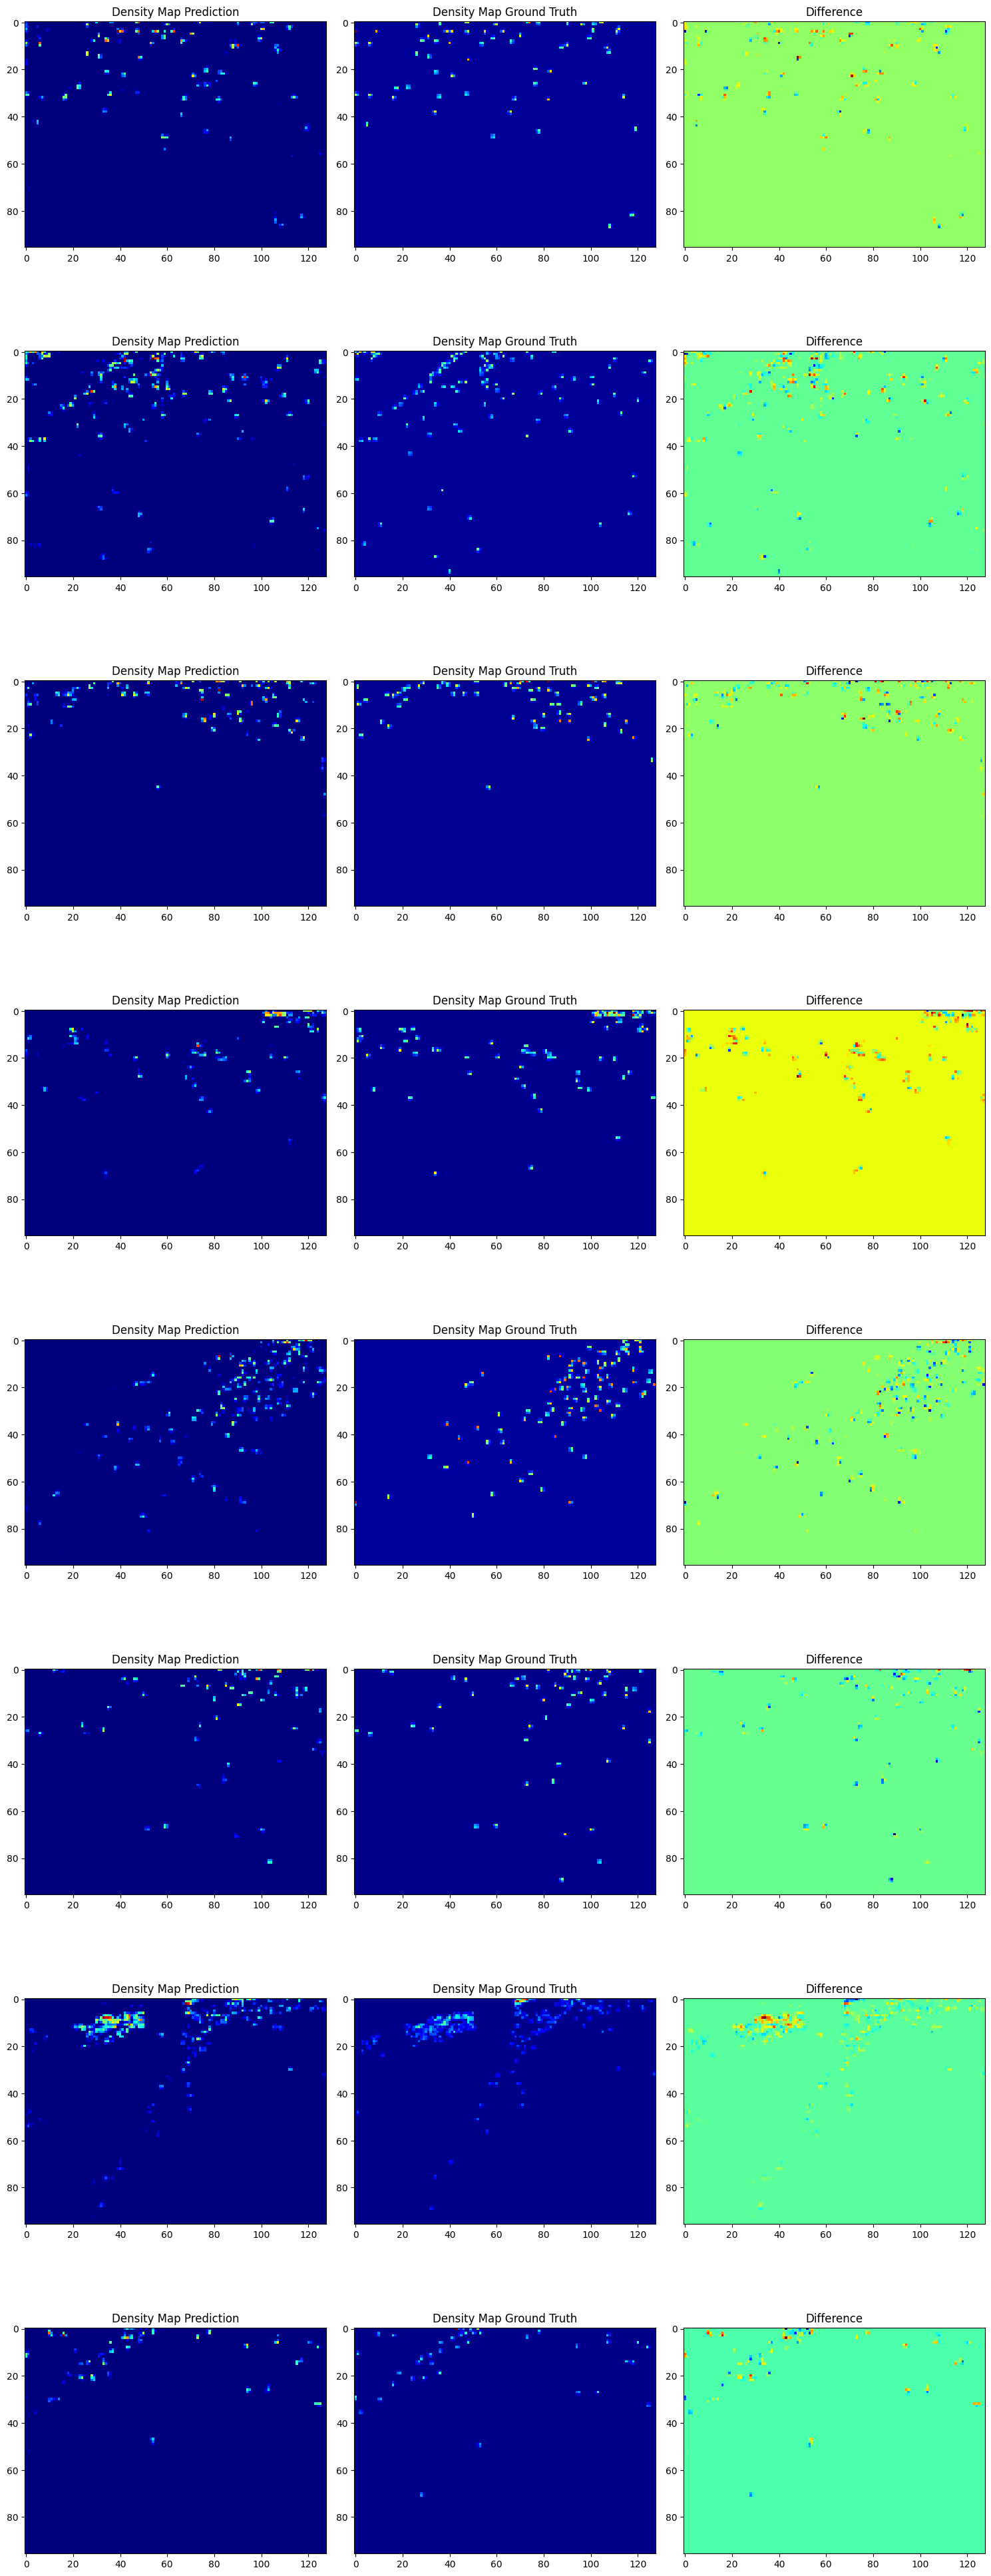

Test RMSE: 19.4112, Test MAE: 12.9784


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = VGGSFCN().to(device)
net.load_state_dict(torch.load(f'{net.__class__.__name__}_best_model.pth'))
test_loader, log_para, restore_transform = get_data_loader('./dataset', batch_size=8, mode='test')
test_rmse, test_mae = test(net, test_loader, device, log_para)
print(f'Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}')